In [36]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from pandas.api.types import is_string_dtype,is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV

%matplotlib inline

In [2]:
path = '/Users/terencenwachi/Downloads'

In [6]:
my_df = pd.read_csv(f'{path}/SpotifyFeatures.csv')
print(my_df.shape)
my_df.head(2)

(232725, 18)


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.0,C#,0.346,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.0,F#,0.151,-5.559,Minor,0.0868,174.003,4/4,0.816


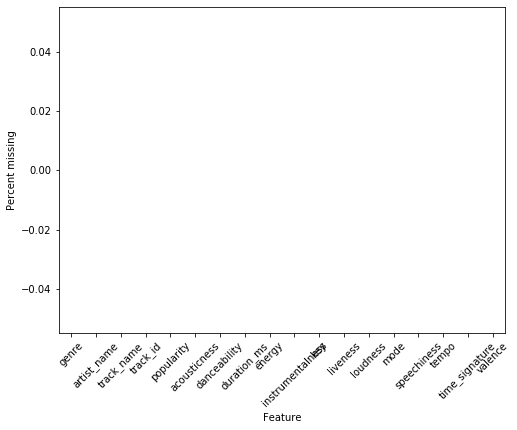

In [7]:

null_vals = my_df.isnull().sum()/len(my_df)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [8]:
def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [9]:
df_2 = str_to_cat(my_df)
print(df_2.shape)
df_2.head(3)

(232725, 18)


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.0,C#,0.346,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.0,F#,0.151,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.0,C,0.103,-13.879,Minor,0.0362,99.488,5/4,0.368


In [11]:
df_2 = df_2.drop(['track_name','artist_name','track_id'], axis = 1)

In [29]:
df_3,my_table = mydf_preprocessor(df_2,null_table = None)
print(df_3.shape)
df_3.head(3)

(232725, 15)


,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,16,0,0.611,0.389,99373,0.910,0.0,5,0.346,-1.828,1,0.0525,166.969,4,0.814
1,16,1,0.246,0.590,137373,0.737,0.0,10,0.151,-5.559,2,0.0868,174.003,4,0.816
2,16,3,0.952,0.663,170267,0.131,0.0,4,0.103,-13.879,2,0.0362,99.488,5,0.368


In [30]:
df_3['popularity'].max()

100

In [31]:
df_3.loc[df_3['popularity'] < 50, 'popularity'] = 0 
df_3.loc[df_3['popularity'] >= 50, 'popularity'] = 1
df_3.head(3)

,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,16,0,0.611,0.389,99373,0.910,0.0,5,0.346,-1.828,1,0.0525,166.969,4,0.814
1,16,0,0.246,0.590,137373,0.737,0.0,10,0.151,-5.559,2,0.0868,174.003,4,0.816
2,16,0,0.952,0.663,170267,0.131,0.0,4,0.103,-13.879,2,0.0362,99.488,5,0.368


In [33]:
pop = len(df_3[df_3['popularity'] == 1])
print(pop)

85017


In [34]:
x = df_3.drop('popularity', axis=1)
y = df_3['popularity']

In [35]:
# Train- Test Split
(X_train, X_test, Y_train, Y_test) = train_test_split(x, y, test_size=0.33, random_state=1)

(X_train, X_val, Y_train, Y_val) = train_test_split(X_train, Y_train, test_size=0.25, random_state=1)
print(X_train.shape,X_test.shape,X_val.shape, Y_val.shape,Y_train.shape,Y_test.shape)

(116943, 14) (76800, 14) (38982, 14) (38982,) (116943,) (76800,)


In [42]:
#List Hyperparameters that we want to tune.
n_estimators = [10, 20, 100, 500,1000]

#Convert to dictionary
hyperparameters = dict(n_estimators=n_estimators)
#Create new KNN object
rf = RandomForestClassifier()
#Use GridSearch
grid_search = GridSearchCV(rf, hyperparameters)
#Fit the model
best_model = grid_search.fit(X_val,Y_val)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['n_estimators'])


/Users/terencenwachi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best leaf_size: 500


In [46]:
model = RandomForestClassifier(n_jobs = -1, n_estimators = 500,
                                 bootstrap = True)
model.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [47]:
Y_prd = model.predict(X_val)
accuracy_score(Y_val,Y_prd)

0.86226976553281